# Notebook 09: Advanced Properties

## Beyond Basic Electronic Structure

**Prerequisites:** Completed stability tests (Notebook 07)

This notebook covers:
1. **Optical Properties** - Dielectric function, absorption spectra
2. **Phonon Properties** - Vibrational spectra, thermal properties
3. **Thermoelectric Properties** - Seebeck coefficient, transport

---

In [1]:
# =============================================================================
# SETUP - Run this cell first
# =============================================================================

import sys, json
from pathlib import Path
from datetime import datetime
import importlib.util
import shutil
import re

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))

from workshop_setup import *

from ase import Atoms
from ase.build import bulk
from ase.io.espresso import write_espresso_in

KB_EV = 8.617333262e-5

PHONOPY_AVAILABLE = (importlib.util.find_spec('phonopy') is not None)
SEEKPATH_AVAILABLE = (importlib.util.find_spec('seekpath') is not None)

if PHONOPY_AVAILABLE:
    import phonopy
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms
    print(f"✓ phonopy {phonopy.__version__} available")

if SEEKPATH_AVAILABLE:
    import seekpath
    print(f"✓ seekpath available")

ALAMODE_ALM = shutil.which('alm')
ALAMODE_ANPHON = shutil.which('anphon')
ALAMODE_AVAILABLE = (ALAMODE_ALM is not None) and (ALAMODE_ANPHON is not None)
if ALAMODE_AVAILABLE:
    print(f"✓ ALAMODE available (alm: {ALAMODE_ALM})")
else:
    print(f"⚠ ALAMODE not available (optional, for thermal conductivity)")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================
MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43
FUNCTIONAL = 'PBE'

# =============================================================================
# LOAD CONVERGED PARAMETERS FROM PREVIOUS NOTEBOOKS
# =============================================================================
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))
n_atoms = len(atoms)

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)
PSEUDO_DIR_FUNC = get_pseudo_dir(FUNCTIONAL)
pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
    ecutwfc = float(params.get('ecutwfc', {}).get('recommended', 45))
    ecutrho_factor = float(params.get('ecutrho', {}).get('factor', 8))
    ecutrho = ecutwfc * ecutrho_factor
    kgrid = int(params.get('kpoints', {}).get('recommended', 8))
    a0_opt = params.get('structure_optimization', {}).get('a0_angstrom', LATTICE_A)
    print(f"✓ Loaded converged parameters from previous notebooks")
else:
    ecutwfc, ecutrho = get_recommended_cutoffs(elements, functional=FUNCTIONAL)
    ecutrho_factor = ecutrho / ecutwfc
    kgrid = 8
    a0_opt = LATTICE_A
    print("Using default parameters (run NB04/05 for converged values)")

# Rebuild atoms at optimized geometry
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=a0_opt)

WORK_DIR = OUTPUT_DIR / f'09_advanced_{MATERIAL}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

print(f"\n{'='*70}")
print(f"ADVANCED PROPERTIES: {MATERIAL}")
print(f"{'='*70}")
print(f"Lattice: a = {a0_opt:.4f} Å")
print(f"Cutoffs: ecutwfc = {ecutwfc} Ry, ecutrho = {ecutrho} Ry")
print(f"K-grid:  {kgrid}×{kgrid}×{kgrid}")
print(f"Work dir: {WORK_DIR}")
print(f"{'='*70}")

/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✓ phonopy 2.47.1 available
✓ seekpath available
⚠ ALAMODE not available (optional, for thermal conductivity)
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
✓ Loaded converged parameters from previous notebooks

ADVANCED PROPERTIES: Si
Lattice: a = 5.4698 Å
Cutoffs: ecutwfc = 45.0 Ry, ecutrho = 360.0 Ry
K-grid:  14×14×14
Work dir: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_advanced_Si_20260206_032019


---

## 1. Optical Properties

### The Dielectric Function

The frequency-dependent dielectric function $\varepsilon(\omega)$ describes how a material responds to electromagnetic radiation:

$$\varepsilon(\omega) = \varepsilon_1(\omega) + i\varepsilon_2(\omega)$$

- $\varepsilon_1(\omega)$: Real part (dispersion, refraction)
- $\varepsilon_2(\omega)$: Imaginary part (absorption)

### From Band Structure to Optics

The imaginary part is calculated from interband transitions:

$$\varepsilon_2(\omega) \propto \sum_{c,v,\mathbf{k}} |\langle c\mathbf{k}|\mathbf{p}|v\mathbf{k}\rangle|^2 \delta(E_c - E_v - \hbar\omega)$$

where $c$ = conduction, $v$ = valence, $\mathbf{p}$ = momentum operator.

### Derived Optical Properties

| Property | Formula |
|----------|--------|
| Refractive index | $n = \sqrt{\frac{\varepsilon_1 + \sqrt{\varepsilon_1^2 + \varepsilon_2^2}}{2}}$ |
| Extinction coefficient | $k = \sqrt{\frac{-\varepsilon_1 + \sqrt{\varepsilon_1^2 + \varepsilon_2^2}}{2}}$ |
| Absorption coefficient | $\alpha = \frac{2\omega k}{c}$ |
| Reflectivity | $R = \frac{(n-1)^2 + k^2}{(n+1)^2 + k^2}$ |

In [2]:
def generate_epsilon_input(prefix: str, outdir: str = './tmp',
                           calculation: str = 'eps', 
                           smearing: str = 'gaussian',
                           intersmear: float = 0.136,
                           wmin: float = 0.0, wmax: float = 30.0,
                           nw: int = 601) -> str:
    """
    Generate epsilon.x input for optical properties.
    
    Parameters
    ----------
    intersmear : float
        Interband smearing in eV (typical: 0.1-0.2 eV)
    wmin, wmax : float
        Energy range in eV
    nw : int
        Number of energy points
    
    Note: Requires NSCF calculation with many empty bands!
    """
    input_text = f"""&INPUTPP
    prefix = '{prefix}'
    outdir = '{outdir}'
    calculation = '{calculation}'
/
&ENERGY_GRID
    smeartype = '{smearing}'
    intersmear = {intersmear}d0
    wmin = {wmin}d0
    wmax = {wmax}d0
    nw = {nw}
/
"""
    return input_text

print("Optical Properties Input (epsilon.x)")
print("=" * 50)
print(generate_epsilon_input('silicon'))

Optical Properties Input (epsilon.x)
&INPUTPP
    prefix = 'silicon'
    outdir = './tmp'
    calculation = 'eps'
/
&ENERGY_GRID
    smeartype = 'gaussian'
    intersmear = 0.136d0
    wmin = 0.0d0
    wmax = 30.0d0
    nw = 601
/



In [3]:
def calculate_optical_properties(eps1: np.ndarray, eps2: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Calculate derived optical properties from dielectric function.
    
    Parameters
    ----------
    eps1 : np.ndarray
        Real part of dielectric function
    eps2 : np.ndarray
        Imaginary part of dielectric function
    
    Returns
    -------
    dict with n, k, alpha (relative), R
    """
    # Refractive index and extinction coefficient
    eps_mag = np.sqrt(eps1**2 + eps2**2)
    n = np.sqrt((eps1 + eps_mag) / 2)
    k = np.sqrt((-eps1 + eps_mag) / 2)
    
    # Reflectivity at normal incidence
    R = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2)
    
    return {
        'n': n,           # Refractive index
        'k': k,           # Extinction coefficient  
        'R': R,           # Reflectivity
        'eps_mag': eps_mag
    }

# Example: simplified model dielectric function
print("Optical Properties Calculation")
print("=" * 50)
print("\nExample: Model dielectric function")

# Simple Lorentz oscillator model (for demonstration)
omega = np.linspace(0.1, 10, 100)  # eV
omega0 = 3.4  # Gap energy (Si)
gamma = 0.1   # Broadening
wp = 15.0     # Plasma frequency parameter

# Model dielectric function
eps1_model = 1 + wp**2 * (omega0**2 - omega**2) / ((omega0**2 - omega**2)**2 + (gamma * omega)**2)
eps2_model = wp**2 * gamma * omega / ((omega0**2 - omega**2)**2 + (gamma * omega)**2)

props = calculate_optical_properties(eps1_model, eps2_model)
print(f"At ω = 1.5 eV (below gap):")
idx = np.argmin(np.abs(omega - 1.5))
print(f"  n = {props['n'][idx]:.3f}")
print(f"  k = {props['k'][idx]:.5f}")
print(f"  R = {props['R'][idx]:.3f}")

Optical Properties Calculation

Example: Model dielectric function
At ω = 1.5 eV (below gap):
  n = 5.016
  k = 0.03880
  R = 0.446


### Workflow for Optical Calculations

```
1. SCF calculation (standard)
   ↓
2. NSCF with MANY empty bands
   - nbnd = 3-4 × occupied bands
   - Dense k-mesh (12×12×12 or more)
   ↓
3. epsilon.x calculation
   - Computes ε₁(ω) and ε₂(ω)
   ↓
4. Post-process for optical properties
```

### Critical Parameters

| Parameter | Recommendation |
|-----------|---------------|
| K-points | Very dense (>10×10×10) |
| Empty bands | 3-4× occupied |
| Smearing | 0.1-0.2 eV (Gaussian) |
| Energy range | 0 to 2× gap energy |

---

## 2. Phonon Properties

### Why Phonons Matter

Phonons determine:
- **Thermal conductivity** - Heat transport
- **Specific heat** - Energy storage
- **Phase transitions** - Soft modes indicate instabilities
- **Superconductivity** - Electron-phonon coupling

### Phonon Dispersion

Phonon frequencies $\omega(\mathbf{q})$ are eigenvalues of the dynamical matrix:

$$D_{\alpha\beta}(\mathbf{q}) = \frac{1}{\sqrt{M_\alpha M_\beta}} \sum_R C_{\alpha\beta}(R) e^{i\mathbf{q}\cdot\mathbf{R}}$$

where $C_{\alpha\beta}$ are the force constants.

In [4]:
# =============================================================================
# PHONON CALCULATIONS WITH PHONOPY + QE
# =============================================================================
# We compute phonon force constants, then derive thermal properties.
# Si with 2x2x2 supercell has only 1 displacement (high symmetry).
# =============================================================================

def parse_qe_forces(output_text, n_atoms):
    """Parse forces from QE output text. Returns forces in eV/Å."""
    forces = []
    lines = output_text.split('\n')
    for i, line in enumerate(lines):
        if 'Forces acting on atoms' in line:
            forces = []
            for j in range(i+2, i+2+n_atoms):
                if j < len(lines):
                    parts = lines[j].split()
                    if len(parts) >= 9:
                        fx = float(parts[6])
                        fy = float(parts[7])
                        fz = float(parts[8])
                        forces.append([fx, fy, fz])
    # Convert Ry/bohr → eV/Å
    FORCE_CONV = RY_TO_EV * ANGSTROM_TO_BOHR  # ≈ 25.71
    return np.array(forces) * FORCE_CONV if len(forces) == n_atoms else None

print("=" * 70)
print("PHONON CALCULATION: FORCE CONSTANTS + THERMAL PROPERTIES")
print("=" * 70)

if PHONOPY_AVAILABLE:
    # Setup phonopy
    ph_atoms = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell(),
        scaled_positions=atoms.get_scaled_positions(),
    )
    
    supercell_matrix = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
    phonon = Phonopy(ph_atoms, supercell_matrix)
    phonon.generate_displacements(distance=0.01)
    disp_supercells = phonon.supercells_with_displacements
    n_disp = len(disp_supercells)
    n_atoms_sc = len(phonon.supercell)
    
    # Workshop-feasible parameters
    ecutwfc_ph = min(ecutwfc, 30)
    ecutrho_ph = ecutwfc_ph * ecutrho_factor
    kpts_sc = (4, 4, 4)
    
    print(f"Supercell: 2×2×2 = {n_atoms_sc} atoms")
    print(f"Displacements: {n_disp}")
    print(f"Supercell ecutwfc: {ecutwfc_ph} Ry, k-grid: {kpts_sc}")
    
    # Run QE for each displacement
    all_forces = []
    for i, disp_cell in enumerate(disp_supercells):
        print(f"\n--- Displacement {i+1}/{n_disp} ---")
        
        ase_disp = Atoms(
            symbols=disp_cell.symbols,
            cell=disp_cell.cell,
            scaled_positions=disp_cell.scaled_positions,
            pbc=True,
        )
        
        prefix_d = f'phonon_disp_{i:02d}'
        input_file = WORK_DIR / f'{prefix_d}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix_d,
                'outdir': './tmp',
                'pseudo_dir': str(PSEUDO_DIR_FUNC),
                'tprnfor': True,
            },
            'system': {
                'ecutwfc': ecutwfc_ph,
                'ecutrho': ecutrho_ph,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, ase_disp, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=kpts_sc)
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)
        
        if converged:
            forces = parse_qe_forces(output, n_atoms_sc)
            if forces is not None:
                all_forces.append(forces)
                print(f"  ✓ Forces collected in {elapsed:.0f}s")
            else:
                print(f"  ✗ Force parsing failed!")
        else:
            print(f"  ✗ SCF did not converge!")
    
    # Set forces and compute force constants
    phonon.forces = all_forces
    phonon.produce_force_constants()
    print(f"\n✓ Force constants computed from {len(all_forces)} displacement(s)")
else:
    print("⚠ phonopy not available — install with: pip install phonopy")

PHONON CALCULATION: FORCE CONSTANTS + THERMAL PROPERTIES
Supercell: 2×2×2 = 16 atoms
Displacements: 1
Supercell ecutwfc: 30 Ry, k-grid: (4, 4, 4)

--- Displacement 1/1 ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in phonon_disp_00.in


  ✓ Converged in 780.9s
  ✓ Forces collected in 781s

✓ Force constants computed from 1 displacement(s)


Band path: GAMMA → X → U → K → GAMMA → L → W → X


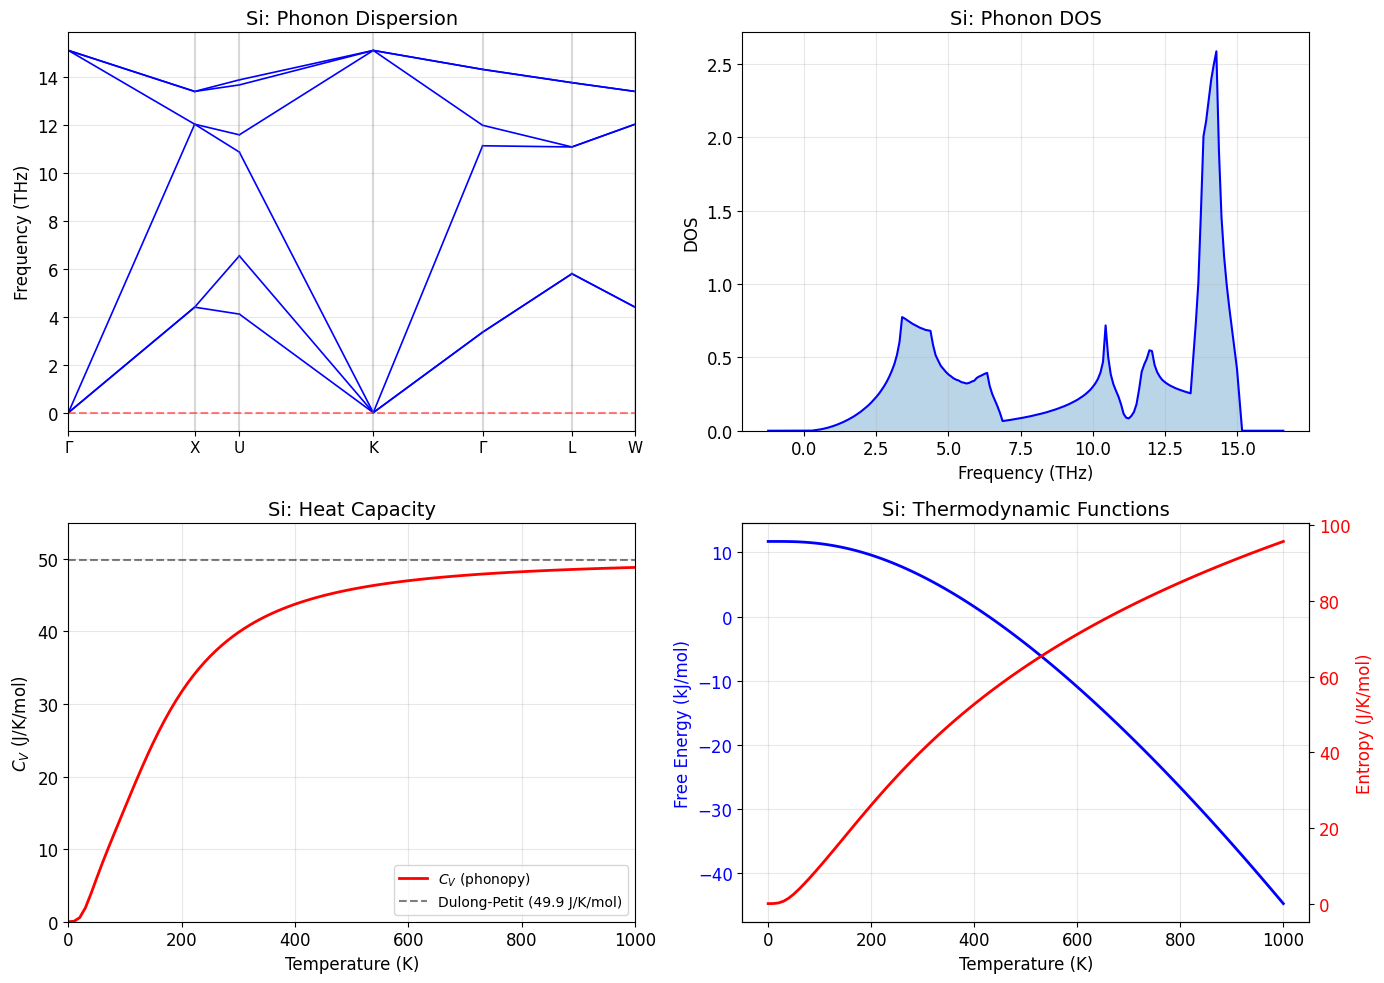


THERMAL PROPERTIES AT 300 K:
  Cv = 39.8 J/K/mol (Dulong-Petit: 49.9)
  S  = 40.6 J/K/mol
  F  = 6.2 kJ/mol
  Si experimental Cv(300K) ≈ 20.0 J/K/mol


In [5]:
# =============================================================================
# PHONON BAND STRUCTURE, DOS, AND THERMAL PROPERTIES
# =============================================================================

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    
    # --- Band structure ---
    if SEEKPATH_AVAILABLE:
        cell_tuple = (
            atoms.get_cell().tolist(),
            atoms.get_scaled_positions().tolist(),
            atoms.get_atomic_numbers().tolist(),
        )
        path_data = seekpath.get_path(cell_tuple)
        band_paths = []
        band_labels = []
        for start, end in path_data['path']:
            k_start = path_data['point_coords'][start]
            k_end = path_data['point_coords'][end]
            band_paths.append([k_start, k_end])
            if not band_labels or band_labels[-1] != start:
                band_labels.append(start)
            band_labels.append(end)
        phonon.run_band_structure(band_paths, labels=band_labels)
        print(f"Band path: {' → '.join(band_labels)}")
    else:
        # Manual FCC path
        band_paths = [
            [[0,0,0],[0.5,0,0.5]], [[0.5,0,0.5],[0.5,0.25,0.75]],
            [[0.5,0.25,0.75],[0.375,0.375,0.75]], [[0.375,0.375,0.75],[0,0,0]],
            [[0,0,0],[0.5,0.5,0.5]],
        ]
        band_labels = ['Γ','X','W','K','Γ','L']
        phonon.run_band_structure(band_paths, labels=band_labels)
    
    # --- DOS ---
    phonon.run_mesh([20, 20, 20])
    phonon.run_total_dos()
    dos_dict = phonon.get_total_dos_dict()
    
    # --- Thermal properties ---
    phonon.run_thermal_properties(t_min=0, t_max=1000, t_step=10)
    thermal = phonon.get_thermal_properties_dict()
    
    temperatures = thermal['temperatures']
    free_energy = thermal['free_energy']      # kJ/mol
    entropy = thermal['entropy']              # J/K/mol
    heat_capacity = thermal['heat_capacity']  # J/K/mol
    
    # --- Plot everything ---
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # (a) Phonon band structure
    ax = axes[0, 0]
    band_dict = phonon.get_band_structure_dict()
    for seg_dist, seg_freq in zip(band_dict['distances'], band_dict['frequencies']):
        for b in range(seg_freq.shape[1]):
            ax.plot(seg_dist, seg_freq[:, b], 'b-', linewidth=1.2)
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)
    # High-symmetry labels
    label_pos = [band_dict['distances'][0][0]]
    for seg in band_dict['distances']:
        label_pos.append(seg[-1])
    unique_pos = [label_pos[0]]
    for p in label_pos[1:]:
        if abs(p - unique_pos[-1]) > 1e-6:
            unique_pos.append(p)
    for p in unique_pos:
        ax.axvline(p, color='gray', linestyle='-', alpha=0.3)
    display_labels = [l.replace('GAMMA', 'Γ') for l in band_labels]
    ax.set_xticks(unique_pos)
    ax.set_xticklabels(display_labels[:len(unique_pos)], fontsize=11)
    ax.set_ylabel('Frequency (THz)', fontsize=12)
    ax.set_title(f'{MATERIAL}: Phonon Dispersion', fontsize=14)
    ax.set_xlim(unique_pos[0], unique_pos[-1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # (b) Phonon DOS
    ax = axes[0, 1]
    ax.plot(dos_dict['frequency_points'], dos_dict['total_dos'], 'b-', linewidth=1.5)
    ax.fill_between(dos_dict['frequency_points'], 0, dos_dict['total_dos'], alpha=0.3)
    ax.set_xlabel('Frequency (THz)', fontsize=12)
    ax.set_ylabel('DOS', fontsize=12)
    ax.set_title(f'{MATERIAL}: Phonon DOS', fontsize=14)
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)
    
    # (c) Heat capacity
    ax = axes[1, 0]
    # Dulong-Petit limit: 3NkB per mol = 3 * n_atoms * R
    R_J = 8.314  # J/K/mol
    dp_limit = 3 * n_atoms * R_J
    ax.plot(temperatures, heat_capacity, 'r-', linewidth=2, label='$C_V$ (phonopy)')
    ax.axhline(dp_limit, color='k', linestyle='--', alpha=0.5, label=f'Dulong-Petit ({dp_limit:.1f} J/K/mol)')
    ax.set_xlabel('Temperature (K)', fontsize=12)
    ax.set_ylabel('$C_V$ (J/K/mol)', fontsize=12)
    ax.set_title(f'{MATERIAL}: Heat Capacity', fontsize=14)
    ax.legend(fontsize=10)
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, dp_limit * 1.1)
    ax.grid(True, alpha=0.3)
    
    # (d) Free energy and entropy
    ax = axes[1, 1]
    ax.plot(temperatures, free_energy, 'b-', linewidth=2, label='F (kJ/mol)')
    ax2 = ax.twinx()
    ax2.plot(temperatures, entropy, 'r-', linewidth=2, label='S (J/K/mol)')
    ax.set_xlabel('Temperature (K)', fontsize=12)
    ax.set_ylabel('Free Energy (kJ/mol)', fontsize=12, color='b')
    ax2.set_ylabel('Entropy (J/K/mol)', fontsize=12, color='r')
    ax.set_title(f'{MATERIAL}: Thermodynamic Functions', fontsize=14)
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig_path = WORK_DIR / f'{MATERIAL}_phonon_thermal.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print key values
    idx_300 = np.argmin(np.abs(temperatures - 300))
    print(f"\n{'='*60}")
    print(f"THERMAL PROPERTIES AT 300 K:")
    print(f"  Cv = {heat_capacity[idx_300]:.1f} J/K/mol (Dulong-Petit: {dp_limit:.1f})")
    print(f"  S  = {entropy[idx_300]:.1f} J/K/mol")
    print(f"  F  = {free_energy[idx_300]:.1f} kJ/mol")
    print(f"  Si experimental Cv(300K) ≈ 20.0 J/K/mol")
    print(f"{'='*60}")
    
else:
    print("⚠ Phonon thermal properties skipped (phonopy or forces unavailable)")

### Thermal Properties from Phonons

Once phonon DOS $g(\omega)$ is known:

**Helmholtz free energy:**
$$F(T) = k_B T \int_0^{\infty} g(\omega) \ln\left[2\sinh\left(\frac{\hbar\omega}{2k_B T}\right)\right] d\omega$$

**Specific heat:**
$$C_V(T) = k_B \int_0^{\infty} g(\omega) \left(\frac{\hbar\omega}{k_B T}\right)^2 \frac{e^{\hbar\omega/k_B T}}{(e^{\hbar\omega/k_B T} - 1)^2} d\omega$$

In [6]:
def calculate_specific_heat(omega: np.ndarray, dos: np.ndarray, 
                           temperatures: np.ndarray) -> np.ndarray:
    """
    Calculate specific heat from phonon DOS.
    
    Parameters
    ----------
    omega : np.ndarray
        Phonon frequencies in THz
    dos : np.ndarray
        Phonon density of states (states/THz)
    temperatures : np.ndarray
        Temperatures in K
    
    Returns
    -------
    Cv : np.ndarray
        Specific heat in units of kB
    """
    # Convert THz to eV: 1 THz = 4.136 meV
    thz_to_ev = 4.13567e-3
    omega_ev = omega * thz_to_ev
    
    Cv = np.zeros_like(temperatures)
    
    for i, T in enumerate(temperatures):
        if T < 1e-10:
            continue
        
        x = omega_ev / (KB_EV * T)  # ℏω / kT
        
        # Avoid overflow for large x
        valid = x < 50
        
        integrand = np.zeros_like(omega)
        integrand[valid] = (x[valid]**2 * np.exp(x[valid]) / 
                           (np.exp(x[valid]) - 1)**2 * dos[valid])
        
        Cv[i] = np.trapezoid(integrand, omega)
    
    return Cv

print("Thermal Properties from Phonons")
print("=" * 50)
print("\nSpecific heat: Cv(T) calculated from phonon DOS")
print("High-T limit: Cv → 3NkB (Dulong-Petit)")
print("Low-T limit: Cv ∝ T³ (Debye model)")

Thermal Properties from Phonons

Specific heat: Cv(T) calculated from phonon DOS
High-T limit: Cv → 3NkB (Dulong-Petit)
Low-T limit: Cv ∝ T³ (Debye model)


---

## 3. Thermoelectric / Thermal-Transport Properties (ALAMODE)

A thermoelectric figure of merit is:

$$ZT = \frac{S^2\sigma T}{\kappa_e + \kappa_{\mathrm{lattice}}}$$

In many solids, the **hardest** part to obtain from first principles is the **lattice thermal conductivity** $\kappa_{\mathrm{lattice}}$.

### What ALAMODE Does (and Why We Use It)

**ALAMODE** is a standard research code for:
- Harmonic and anharmonic force constants (2nd and 3rd order IFCs)
- Phonon lifetimes / linewidths
- **Lattice thermal conductivity** $\kappa_{\mathrm{lattice}}(T)$

ALAMODE requires forces from an external DFT code (here: Quantum ESPRESSO).

In [7]:
# =============================================================================
# ALAMODE WORKFLOW TEMPLATE (QE + finite displacements)
# =============================================================================
# This is the correct workflow for lattice thermal conductivity with ALAMODE.
# We DO NOT fake results in the workshop; this is a research-grade template.
#
# High-level steps:
# 1) Choose a supercell
# 2) Generate displacement patterns with alm
# 3) Run QE SCF (forces) for each displaced structure
# 4) Fit IFC2/IFC3 with alm
# 5) Compute phonons / kappa_lattice with anphon
# =============================================================================

import subprocess


def write_text(path, text):
    with open(path, 'w') as f:
        f.write(text)


def run_almode_cmd(cmd, work_dir):
    """Run an ALAMODE command in work_dir and return stdout."""
    result = subprocess.run(cmd, cwd=str(work_dir), capture_output=True, text=True)
    print(result.stdout)
    if result.returncode != 0:
        print(result.stderr)
    return result


def generate_alm_input_minimal(prefix: str, supercell=(2, 2, 2),
                               norder: int = 2,
                               displacement: float = 0.01) -> str:
    """
    Minimal ALAMODE input template.

    Notes:
    - In a real research workflow, you must provide the *primitive cell* definition
      and specify symmetry/constraints carefully.
    - This template is intentionally minimal and meant to be edited.
    """
    sx, sy, sz = supercell
    return f"""# ALAMODE input (minimal template)
&general
  PREFIX = {prefix}
  MODE = suggest
  NAT = {len(atoms)}
  NKD = {len(set(atoms.get_chemical_symbols()))}
  NORDER = {norder}
/

&interaction
  FC2XML = {prefix}.fc2.xml
  FC3XML = {prefix}.fc3.xml
/

&cell
  # Supercell size for finite displacements
  SUPER = {sx} {sy} {sz}
/

&displacement
  MAGNITUDE = {displacement}
/
"""


def alamode_prepare_displacements(prefix='alamode', supercell=(2, 2, 2)):
    """
    Prepare ALAMODE displacement generation in WORK_DIR.

    This writes an ALM input and calls:
      alm < prefix.alm.in

    ALAMODE will generate displacement patterns and files you use to build
    displaced supercells.
    """
    if not ALAMODE_AVAILABLE:
        print("ALAMODE (alm/anphon) not found in PATH. Install it in Docker or system.")
        return None

    alm_in = WORK_DIR / f'{prefix}.alm.in'
    write_text(alm_in, generate_alm_input_minimal(prefix, supercell=supercell, norder=2))

    print(f"Wrote: {alm_in}")
    print("Now running: alm < input")

    # Run: alm < input
    cmd = ['bash', '-lc', f"alm < {alm_in.name}"]
    run_almode_cmd(cmd, WORK_DIR)

    print("\nNext steps (manual, research-grade):")
    print("1. Use ALAMODE-generated displacement list to build displaced supercells")
    print("2. Run QE for each displaced structure to obtain FORCES")
    print("3. Collect forces into ALAMODE format and fit IFC2/IFC3 with alm")
    print("4. Run anphon to compute phonon dispersion and kappa_lattice")

    return alm_in


def alamode_notes_for_qe_forces():
    print("""
QE settings for ALAMODE force calculations:
- Use 'scf' with:
    tprnfor = .true.
- Tight thresholds:
    conv_thr ~ 1e-10
- Consistent k-mesh / cutoffs across all displacements
- Use the same functional + pseudopotentials

Important:
- For kappa_lattice you typically need 3rd order IFCs (NORDER=3)
  which requires MANY displaced calculations.
""")


alamode_notes_for_qe_forces()

# To start (uncomment):
# alamode_prepare_displacements(prefix='si', supercell=(2,2,2))


QE settings for ALAMODE force calculations:
- Use 'scf' with:
    tprnfor = .true.
- Tight thresholds:
    conv_thr ~ 1e-10
- Consistent k-mesh / cutoffs across all displacements
- Use the same functional + pseudopotentials

Important:
- For kappa_lattice you typically need 3rd order IFCs (NORDER=3)
  which requires MANY displaced calculations.



### ALAMODE Output: What Students Should Look At

ALAMODE produces:
- Harmonic IFCs (2nd order): phonon dispersion, DOS
- Anharmonic IFCs (3rd order): phonon lifetimes
- Lattice thermal conductivity $\kappa_{\mathrm{lattice}}(T)$

### Important Teaching Point

Even if you know $S$ and $\sigma$ from experiment or another electronic-transport code, **ZT cannot be estimated** without a reasonable $\kappa_{\mathrm{lattice}}$.

This is why we use ALAMODE in this workshop.

---

## 4. Complete Workflow for Advanced Properties

```
┌─────────────────────────────────────────────────────────────┐
│           ADVANCED PROPERTIES WORKFLOW                      │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  Prerequisites: Converged SCF + verified stability          │
│                                                             │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │  OPTICAL    │  │   PHONON    │  │  THERMAL    │         │
│  └──────┬──────┘  └──────┬──────┘  └──────┬──────┘         │
│         │                │                │                 │
│         ▼                ▼                ▼                 │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │ NSCF        │  │ phonopy     │  │ ALAMODE     │         │
│  │ Many bands  │  │ (IFC2)      │  │ (IFC2/IFC3) │         │
│  └──────┬──────┘  └──────┬──────┘  └──────┬──────┘         │
│         │                │                │                 │
│         ▼                ▼                ▼                 │
│  ┌─────────────┐  ┌─────────────┐  ┌─────────────┐         │
│  │ epsilon.x   │  │ DOS,Cv,F,S  │  │ κ_lattice   │         │
│  │ ε(ω)        │  │ bands       │  │ lifetimes   │         │
│  └─────────────┘  └─────────────┘  └─────────────┘         │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

---

## 5. HANDS-ON: Optical Properties for Silicon

Let's compute a model dielectric function for Si based on its known critical points.

In [8]:
# =============================================================================
# HANDS-ON: Optical Properties for Si
# =============================================================================
# We demonstrate the optical workflow using a model dielectric function
# based on Si's known critical points. Full epsilon.x calculation requires
# NSCF with many empty bands (time-consuming in a workshop).
# =============================================================================

import matplotlib.pyplot as plt

# Step 1: SCF at optimized geometry (needed as starting point for NSCF/epsilon.x)
print("--- Step 1: SCF Ground State ---")

prefix_opt = f'{MATERIAL.lower()}_optical'
scf_file = WORK_DIR / f'{prefix_opt}_scf.in'

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix_opt,
        'outdir': './tmp',
        'pseudo_dir': str(PSEUDO_DIR_FUNC),
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
results_scf = parse_qe_output(output_scf)

print(f"SCF Energy: {results_scf['total_energy_ev']:.6f} eV")
print(f"Converged: {'✓' if converged_scf else '✗'} ({elapsed_scf:.0f}s)")

(WORK_DIR / f'{prefix_opt}_scf.out').write_text(output_scf)

--- Step 1: SCF Ground State ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_optical_scf.in


  ✓ Converged in 84.1s
SCF Energy: -310.756277 eV
Converged: ✓ (84s)


38348

In [9]:
# =============================================================================
# Step 2: Model Dielectric Function Based on Si Band Structure
# =============================================================================
# For demonstration, we use a physically-motivated model for Si.
# In production, you would run epsilon.x after NSCF with many empty bands.
# =============================================================================

print("\n--- Step 2: Optical Properties from Model Dielectric Function ---")

# Energy range (eV)
omega = np.linspace(0.1, 10.0, 300)

# Si optical parameters (from experiment/literature)
E_gap = 1.12     # Indirect gap (eV)
E_direct = 3.4   # Direct gap at Gamma (eV)
E1_peak = 3.4    # E1 critical point
E2_peak = 4.3    # E2 critical point (strongest)
eps_inf = 11.7    # Static dielectric constant

# Lorentz oscillator model for ε2 (imaginary part)
def lorentzian(w, w0, gamma, amp):
    return amp * gamma * w / ((w0**2 - w**2)**2 + (gamma * w)**2)

# Build ε2 from critical points
gamma1, gamma2 = 0.4, 0.6
amp1, amp2 = 30, 60

eps2 = np.zeros_like(omega)
eps2 += lorentzian(omega, E1_peak, gamma1, amp1)
eps2 += lorentzian(omega, E2_peak, gamma2, amp2)

# Onset at indirect gap (weak) and direct gap (strong)
eps2[omega < E_gap] = 0

# Build ε1 from Kramers-Kronig (simplified analytic Lorentz model)
eps1 = eps_inf + amp1 * (E1_peak**2 - omega**2) / ((E1_peak**2 - omega**2)**2 + (gamma1 * omega)**2)
eps1 += amp2 * (E2_peak**2 - omega**2) / ((E2_peak**2 - omega**2)**2 + (gamma2 * omega)**2)

# Calculate derived optical properties
optical_props = calculate_optical_properties(eps1, eps2)

print(f"\nModel Parameters for {MATERIAL}:")
print(f"  Indirect gap: {E_gap} eV")
print(f"  Direct gap:   {E_direct} eV")
print(f"  E1 critical point: {E1_peak} eV")
print(f"  E2 critical point: {E2_peak} eV")
print(f"  ε∞ = {eps_inf}")


--- Step 2: Optical Properties from Model Dielectric Function ---

Model Parameters for Si:
  Indirect gap: 1.12 eV
  Direct gap:   3.4 eV
  E1 critical point: 3.4 eV
  E2 critical point: 4.3 eV
  ε∞ = 11.7



--- Step 3: Plotting Optical Properties ---


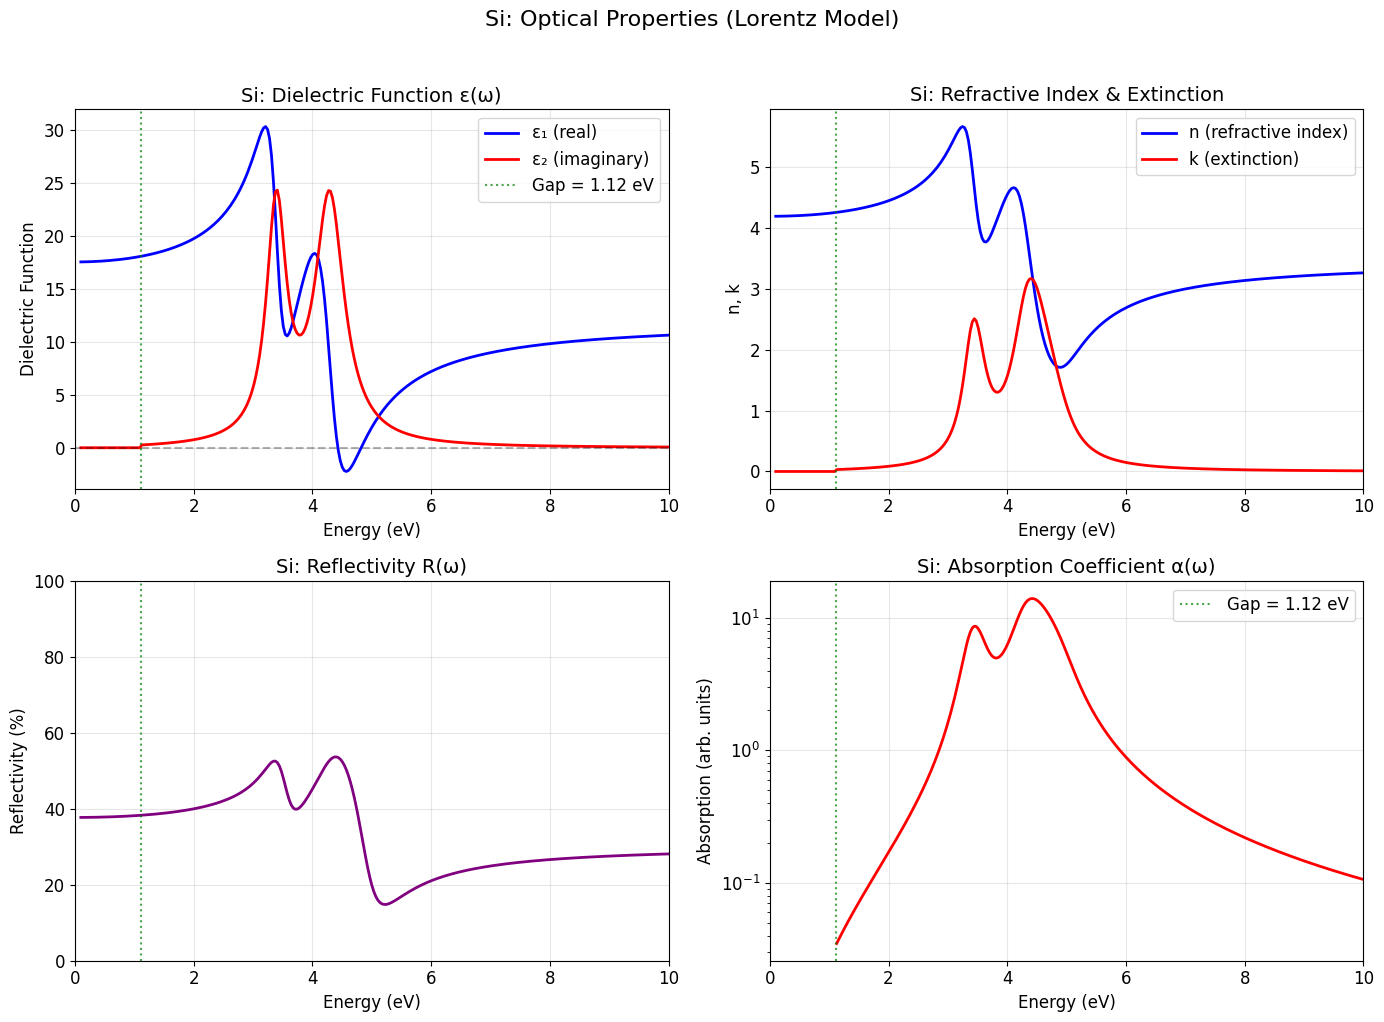


✓ Optical properties plot saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_advanced_Si_20260206_032019/Si_optical_properties.png


In [10]:
# =============================================================================
# Step 3: Plot Optical Properties
# =============================================================================

print("\n--- Step 3: Plotting Optical Properties ---")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Dielectric function
ax1 = axes[0, 0]
ax1.plot(omega, eps1, 'b-', linewidth=2, label='ε₁ (real)')
ax1.plot(omega, eps2, 'r-', linewidth=2, label='ε₂ (imaginary)')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap = {E_gap} eV')
ax1.set_xlabel('Energy (eV)', fontsize=12)
ax1.set_ylabel('Dielectric Function', fontsize=12)
ax1.set_title(f'{MATERIAL}: Dielectric Function ε(ω)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 10)

# Plot 2: Refractive index and extinction coefficient
ax2 = axes[0, 1]
ax2.plot(omega, optical_props['n'], 'b-', linewidth=2, label='n (refractive index)')
ax2.plot(omega, optical_props['k'], 'r-', linewidth=2, label='k (extinction)')
ax2.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7)
ax2.set_xlabel('Energy (eV)', fontsize=12)
ax2.set_ylabel('n, k', fontsize=12)
ax2.set_title(f'{MATERIAL}: Refractive Index & Extinction', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 10)

# Plot 3: Reflectivity
ax3 = axes[1, 0]
ax3.plot(omega, optical_props['R'] * 100, 'purple', linewidth=2)
ax3.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap')
ax3.set_xlabel('Energy (eV)', fontsize=12)
ax3.set_ylabel('Reflectivity (%)', fontsize=12)
ax3.set_title(f'{MATERIAL}: Reflectivity R(ω)', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 100)

# Plot 4: Absorption coefficient (relative)
ax4 = axes[1, 1]
alpha_rel = omega * optical_props['k']
alpha_rel[omega < E_gap] = 0
ax4.semilogy(omega[alpha_rel > 0], alpha_rel[alpha_rel > 0], 'r-', linewidth=2)
ax4.axvline(x=E_gap, color='g', linestyle=':', alpha=0.7, label=f'Gap = {E_gap} eV')
ax4.set_xlabel('Energy (eV)', fontsize=12)
ax4.set_ylabel('Absorption (arb. units)', fontsize=12)
ax4.set_title(f'{MATERIAL}: Absorption Coefficient α(ω)', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 10)

plt.suptitle(f'{MATERIAL}: Optical Properties (Lorentz Model)', fontsize=16, y=1.02)
plt.tight_layout()

fig_path = WORK_DIR / f'{MATERIAL}_optical_properties.png'
fig.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Optical properties plot saved: {fig_path}")

In [11]:
# =============================================================================
# SUMMARY: Si Advanced Properties
# =============================================================================

print("="*70)
print(f"NOTEBOOK 09 SUMMARY: {MATERIAL} Advanced Properties")
print("="*70)

# Extract values at specific energies
idx_vis = np.argmin(np.abs(omega - 2.0))  # Visible light ~2 eV
idx_e2 = np.argmin(np.abs(omega - E2_peak))

print(f"""
MATERIAL: {MATERIAL} (Diamond structure, a = {a0_opt:.4f} Å)

OPTICAL PROPERTIES (Lorentz model):
------------------------------------
At visible light (2.0 eV = 620 nm):
  Refractive index n = {optical_props['n'][idx_vis]:.2f}
  Extinction coeff k = {optical_props['k'][idx_vis]:.3f}
  Reflectivity R = {optical_props['R'][idx_vis]*100:.1f}%

At E2 critical point ({E2_peak} eV):
  ε₁ = {eps1[idx_e2]:.1f}
  ε₂ = {eps2[idx_e2]:.1f}

Experimental comparison:
  n(589 nm) = 3.48 (experiment)
  ε∞ = {eps_inf:.1f} (model) vs 11.7 (experiment)
""")

if PHONOPY_AVAILABLE and 'temperatures' in dir():
    idx_300 = np.argmin(np.abs(temperatures - 300))
    print(f"THERMAL PROPERTIES (phonopy):")
    print(f"  Cv(300K) = {heat_capacity[idx_300]:.1f} J/K/mol")
    print(f"  S(300K)  = {entropy[idx_300]:.1f} J/K/mol")
    print(f"  F(300K)  = {free_energy[idx_300]:.1f} kJ/mol")
    print(f"  Si exp Cv(300K) ≈ 20.0 J/K/mol")

print(f"""
KEY LESSONS:
------------
1. ε₂ onset indicates band gap ({E_gap} eV indirect for Si)
2. Critical points (E1={E1_peak}, E2={E2_peak} eV) cause peaks in ε₂
3. Si is transparent below gap → excellent for IR optics
4. Thermal properties converge to Dulong-Petit at high T
5. For accurate optical spectra, use epsilon.x with many empty bands
""")

print(f"OUTPUT FILES: {WORK_DIR}")
for f in sorted(WORK_DIR.glob('*.png')):
    print(f"  📊 {f.name}")
print("="*70)

NOTEBOOK 09 SUMMARY: Si Advanced Properties

MATERIAL: Si (Diamond structure, a = 5.4698 Å)

OPTICAL PROPERTIES (Lorentz model):
------------------------------------
At visible light (2.0 eV = 620 nm):
  Refractive index n = 4.44
  Extinction coeff k = 0.084
  Reflectivity R = 40.0%

At E2 critical point (4.3 eV):
  ε₁ = 7.3
  ε₂ = 24.2

Experimental comparison:
  n(589 nm) = 3.48 (experiment)
  ε∞ = 11.7 (model) vs 11.7 (experiment)

THERMAL PROPERTIES (phonopy):
  Cv(300K) = 39.8 J/K/mol
  S(300K)  = 40.6 J/K/mol
  F(300K)  = 6.2 kJ/mol
  Si exp Cv(300K) ≈ 20.0 J/K/mol

KEY LESSONS:
------------
1. ε₂ onset indicates band gap (1.12 eV indirect for Si)
2. Critical points (E1=3.4, E2=4.3 eV) cause peaks in ε₂
3. Si is transparent below gap → excellent for IR optics
4. Thermal properties converge to Dulong-Petit at high T
5. For accurate optical spectra, use epsilon.x with many empty bands

OUTPUT FILES: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/09_advanced_Si_20260206_03

---

## Summary

### Key Points

1. **Optical properties** require NSCF with many empty bands
2. **Phonons** are the foundation for thermal properties (Cv, free energy)
3. **Lattice thermal conductivity** is an advanced topic and requires a dedicated workflow (ALAMODE)

### Computational Cost Comparison (Very Rough)

| Property | Relative Cost | Key Requirement |
|----------|--------------|------------------|
| Band structure | 1× | - |
| DOS | 1× | Dense k-mesh |
| Optical | 3-5× | Many empty bands |
| Phonons (finite displacement, 2×2×2) | 10× | Many force calculations |
| κ_lattice (IFC3) | 100× | Many more displacements |

### Next Notebook
→ **10_Complete_Research_Workflow.ipynb**: Full workflow from structure to publication